# Filtering and Thresholding Design Parameters and Broadband Objective Functions

While cheap gradients are always appreciated, we noticed that the optimizer and adjoint solver often produce devices that are impossible to fabricate. They tend to continuously vary the refractive index and produce small feature sizes. Furthermore, the lack of constraint often throws the optimizer into local minima, stunting the overall progress of the solver.

To overcome this, the Topology Optimization (TO) community often implements linear and nonlinear functional transforms on the design parameters before projecting them onto the simulation domain. For example, we can blur many of the small design parameters together using a conic filter, and subsequently threshold using sigmoid like functions.

The resulting parameters can include constraints, like minimum lengths scales, and project the cost function into a more friendly (and sometimes less friendly) design space.

We'll examine how to accomplish these goals using native `autograd` functions and meep's adjoint solver.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import special, signal
mp.quiet(quietval=True)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

Using MPI version 3.1, 1 processes


Let's choose our basic geometry parameters, along with the frequency range to simulate. If our frequency points are too close together than the resulting adjoint simulation may take longer to simulate each iteration.

In [2]:
waveguide_width = 0.5
design_region_width = 2.5
design_region_height = 2.5

waveguide_length = 0.5

pml_size = 1.0

resolution = 30

frequencies = 1/np.linspace(1.5,1.6,10)

Now we'll specify our smoothing filter radius (in microns). This is determined by our minimum length scale and erosion threshold point. In this example, we won't actually enforce the length scale constraints, but the following machinery is required to do so.

We also need to specify the number of design parameters per meep pixel we want to set up.

In [3]:
minimum_length = 0.09 # minimum length scale (microns)
eta_i = 0.5 # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55 # erosion design field thresholding point (between 0 and 1)
eta_d = 1-eta_e # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e)
print(filter_radius)
design_region_resolution = int(1*resolution)

0.20124611797498096


As before, we'll generate our simulation cell with the specified sources, boundary layers, geometry, etc.

In [4]:
Sx = 2*pml_size + 2*waveguide_length + design_region_width
Sy = 2*pml_size + design_region_height + 0.5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-Sx/2 + pml_size + waveguide_length/3,0,0]
source_size    = mp.Vector3(0,Sy,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

Let's set up our design region. The defauly grid type behaves just like any other geometry object -- the last object in the tree overides any objects underneath it. In some cases, it's important to *average* overlapping design regions, i.e. to enforce particular symmetries. To enable this capability, we'll set our design variables to use the `U_MEAN` grid type.

In [5]:
Nx = int(design_region_resolution*design_region_width)
Ny = int(design_region_resolution*design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si,grid_type='U_MEAN')
design_region = mpa.DesignRegion(design_variables,volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0)))

The optimizer doesn't know anything about the geometry outside of the design region. We can "hint" what parts of the design must be waveguides by forcing boundry constraints. We'll build bitmasks that map the border of the design regions to either silicon or silicon dioxide.

In [6]:
x_g = np.linspace(-design_region_width/2,design_region_width/2,Nx)
y_g = np.linspace(-design_region_height/2,design_region_height/2,Ny)
X_g, Y_g = np.meshgrid(x_g,y_g,sparse=True,indexing='ij')

left_wg_mask = (X_g == -design_region_width/2) & (np.abs(Y_g) <= waveguide_width/2)
top_wg_mask = (Y_g == design_region_width/2) & (np.abs(X_g) <= waveguide_width/2)
Si_mask = left_wg_mask | top_wg_mask

border_mask = ((X_g == -design_region_width/2) | 
               (X_g == design_region_width/2) | 
               (Y_g == -design_region_height/2) | 
               (Y_g == design_region_height/2))
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False

Next, we'll define various filters that perform smoothing, projection, and material scaling. We'll be sure to use autograd so that we can easily backpropogate our gradient provided by the adjoint solver. We have some smoothing and thresholding filters already defined in the adjoint package that we'll use here.

In [7]:
def mapping(x,eta,beta):
    x = npa.where(Si_mask.flatten(),1,npa.where(SiO2_mask.flatten(),0,x))
    # filter
    filtered_field = mpa.conic_filter(x,filter_radius,design_region_width,design_region_height,design_region_resolution)
    
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    
    # interpolate to actual materials
    return projected_field.flatten()

Let's build the geometry and simulation objects. We can force a rotational symmetry by adding extra blocks with the same design variables, but different basis vectors (`e1`, `e2`, etc.) In our case, we need one additional block object rotated by 90 degrees.

Because our design variables are using the `U_MEAN` scheme, the adjoint solver will search for all of the material grids at each point in our design region and average the overlapping design variables. This way, we can enforce our symmetry constraint.

In [8]:
geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=Si, size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=Si, size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables), # design region
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
             e1=mp.Vector3(x=-1).rotate(mp.Vector3(z=1), np.pi/2), e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), np.pi/2))
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    default_material=SiO2,
                    resolution=resolution)

Let's formulate our broadband objective function. To keep it simple we'll just minimize the sum of the error, where the error is the L2 norm between the transmission and 1 (i.e. the desired profile).

In [9]:
mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(x=-Sx/2 + pml_size + 2*waveguide_length/3),size=mp.Vector3(y=Sy)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,Sx/2 - pml_size - 2*waveguide_length/3,0),size=mp.Vector3(x=Sx)),mode)
ob_list = [TE0,TE_top]
def J(source,top):
    power = npa.abs(top/source)
    return npa.mean(power)

In [10]:
opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies,
    decay_by = 1e-4,
    decay_fields=[mp.Ez]
)

Next, let's see how well our filtering and projection functions work.

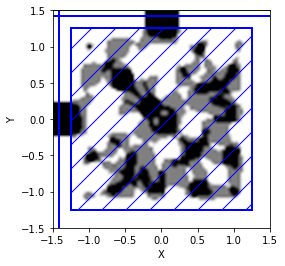

In [11]:
rho_vector = np.random.rand(Nx*Ny)
opt.update_design([mapping(rho_vector,eta_i,1e3)])
opt.plot2D(True,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.show()

We can increase our `beta` term, which controls the thresholding, and simultaneously sweep our perturbation term (`delta`) which is used to generate erosion and dilation geometries typically used in the literature. 

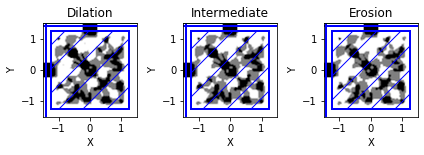

In [12]:
beta = 2048

plt.figure()
ax1 = plt.subplot(1,3,1)
opt.update_design([mapping(rho_vector,0.498,beta)])
opt.plot2D(True,ax=ax1,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.title("Dilation")

ax2 = plt.subplot(1,3,2)
opt.update_design([mapping(rho_vector,0.5,beta)])
opt.plot2D(True,ax=ax2,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.title("Intermediate")

ax3 = plt.subplot(1,3,3)
opt.update_design([mapping(rho_vector,0.502,beta)])
opt.plot2D(True,ax=ax3,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.title("Erosion")

plt.tight_layout()
plt.show()

With our framwork in place, we can define our `nlopt` cost function wrapper that also includes our mapping layers and their corresponding gradients. We'll systematically increase our `beta` term so that the thresholding gradually turns on, as suggested by the literature.

In [13]:
evaluation_history = []
cur_iter = [0]
def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0]+1))
    
    f0, dJ_du = opt([mapping(v,eta_i,cur_beta)]) # compute objective and gradient
    
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping,0)(v,eta_i,cur_beta,np.sum(dJ_du,axis=1)) # backprop
    
    
    evaluation_history.append(np.real(f0))
    
    plt.figure()
    ax = plt.gca()
    opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
    circ = Circle((2,2),minimum_length/2)
    ax.add_patch(circ)
    ax.axis('off')
    plt.show()
    
    cur_iter[0] = cur_iter[0] + 1
    
    return np.real(f0)

We'll now run our optimizer in loop. The loop will increase beta and reset the optimizer, which is important since the cost function changes.

Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...


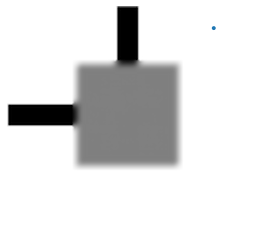

Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...


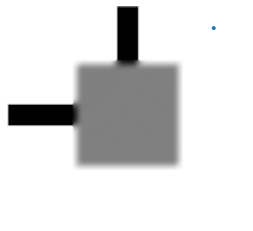

Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...


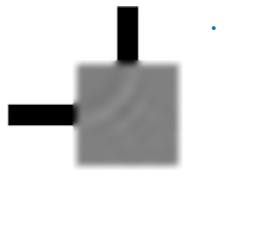

Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


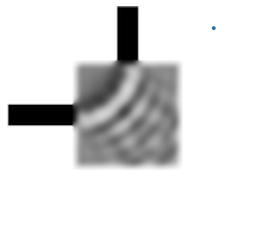

Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...


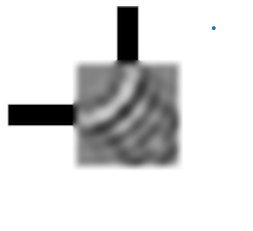

Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...


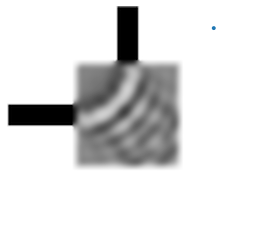

Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...


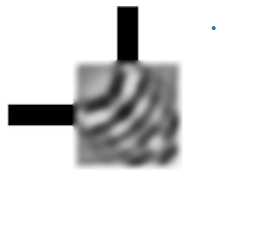

Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


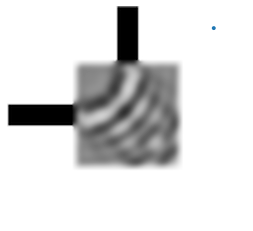

Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...


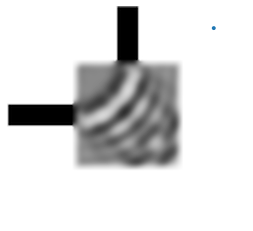

Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...


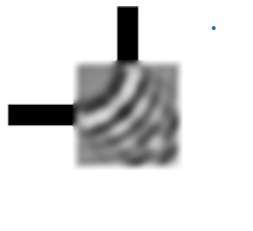

Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...


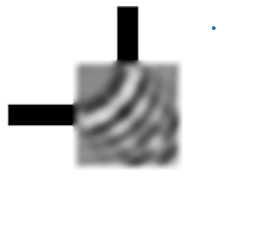

Current iteration: 12
Starting forward run...
Starting adjoint run...
Calculating gradient...


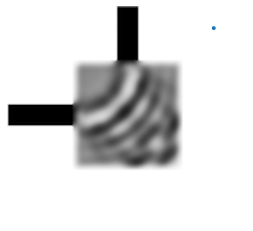

Current iteration: 13
Starting forward run...
Starting adjoint run...
Calculating gradient...


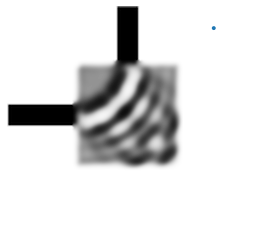

Current iteration: 14
Starting forward run...
Starting adjoint run...
Calculating gradient...


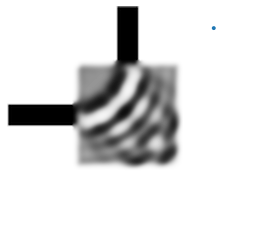

Current iteration: 15
Starting forward run...
Starting adjoint run...
Calculating gradient...


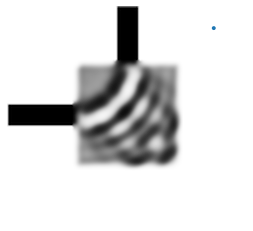

Current iteration: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


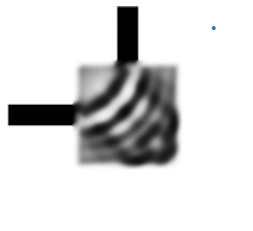

Current iteration: 17
Starting forward run...
Starting adjoint run...
Calculating gradient...


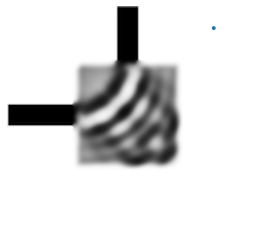

Current iteration: 18
Starting forward run...
Starting adjoint run...
Calculating gradient...


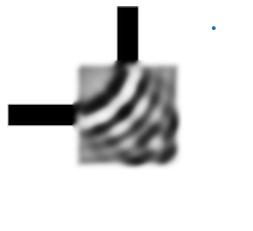

Current iteration: 19
Starting forward run...
Starting adjoint run...
Calculating gradient...


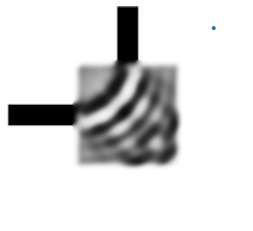

Current iteration: 20
Starting forward run...
Starting adjoint run...
Calculating gradient...


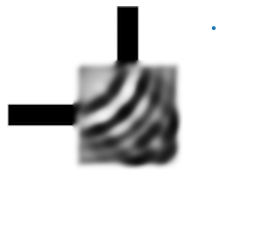

Current iteration: 21
Starting forward run...
Starting adjoint run...
Calculating gradient...


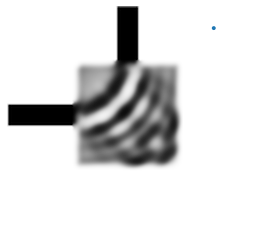

Current iteration: 22
Starting forward run...
Starting adjoint run...
Calculating gradient...


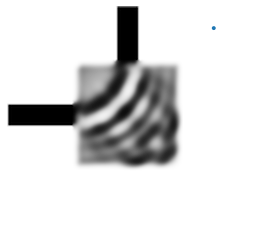

Current iteration: 23
Starting forward run...
Starting adjoint run...
Calculating gradient...


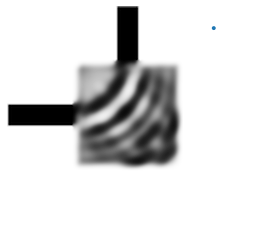

Current iteration: 24
Starting forward run...
Starting adjoint run...
Calculating gradient...


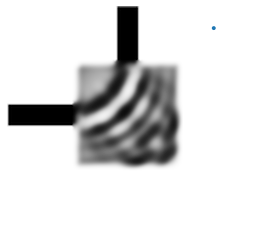

Current iteration: 25
Starting forward run...
Starting adjoint run...
Calculating gradient...


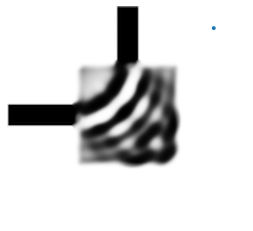

Current iteration: 26
Starting forward run...
Starting adjoint run...
Calculating gradient...


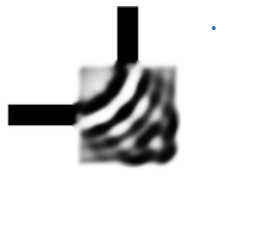

Current iteration: 27
Starting forward run...
Starting adjoint run...
Calculating gradient...


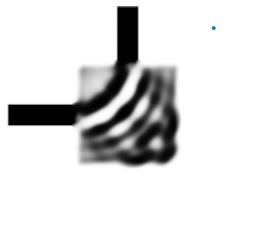

Current iteration: 28
Starting forward run...
Starting adjoint run...
Calculating gradient...


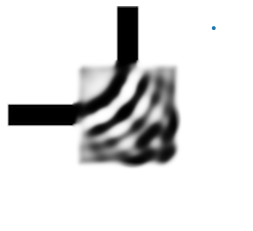

Current iteration: 29
Starting forward run...
Starting adjoint run...
Calculating gradient...


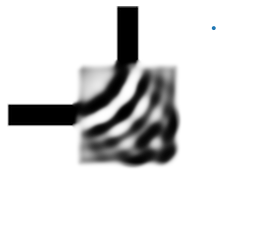

Current iteration: 30
Starting forward run...
Starting adjoint run...
Calculating gradient...


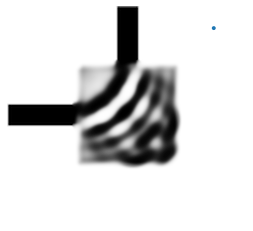

Current iteration: 31
Starting forward run...
Starting adjoint run...
Calculating gradient...


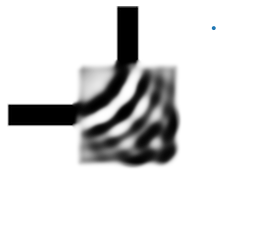

Current iteration: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


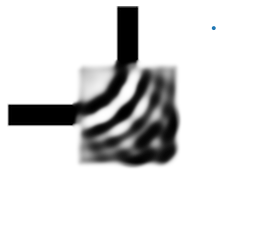

Current iteration: 33
Starting forward run...
Starting adjoint run...
Calculating gradient...


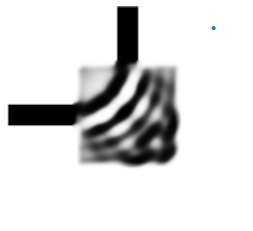

Current iteration: 34
Starting forward run...
Starting adjoint run...
Calculating gradient...


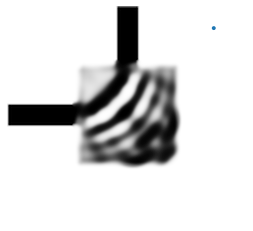

Current iteration: 35
Starting forward run...
Starting adjoint run...
Calculating gradient...


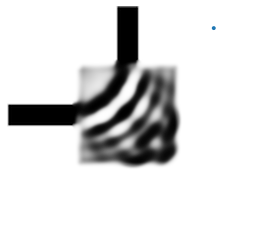

Current iteration: 36
Starting forward run...
Starting adjoint run...
Calculating gradient...


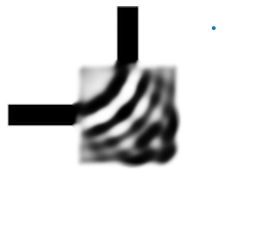

Current iteration: 37
Starting forward run...
Starting adjoint run...
Calculating gradient...


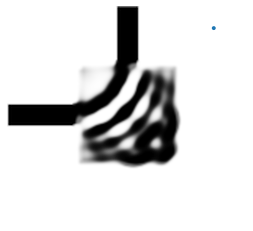

Current iteration: 38
Starting forward run...
Starting adjoint run...
Calculating gradient...


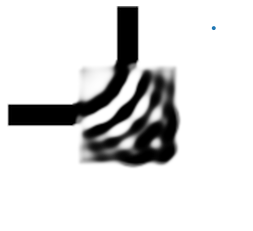

Current iteration: 39
Starting forward run...
Starting adjoint run...
Calculating gradient...


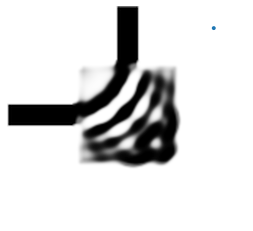

Current iteration: 40
Starting forward run...
Starting adjoint run...
Calculating gradient...


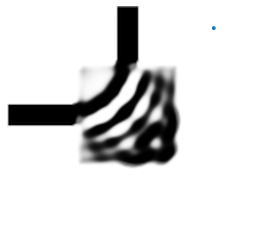

Current iteration: 41
Starting forward run...
Starting adjoint run...
Calculating gradient...


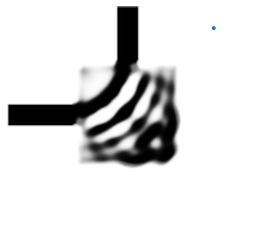

Current iteration: 42
Starting forward run...
Starting adjoint run...
Calculating gradient...


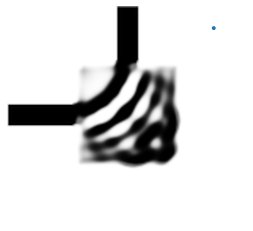

Current iteration: 43
Starting forward run...
Starting adjoint run...
Calculating gradient...


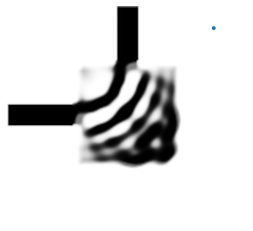

Current iteration: 44
Starting forward run...
Starting adjoint run...
Calculating gradient...


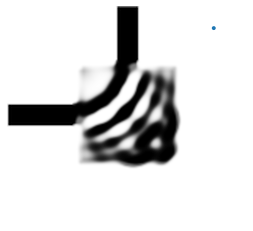

Current iteration: 45
Starting forward run...
Starting adjoint run...
Calculating gradient...


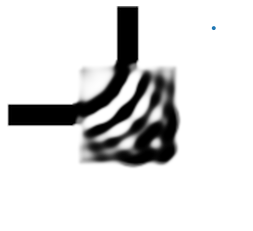

Current iteration: 46
Starting forward run...
Starting adjoint run...
Calculating gradient...


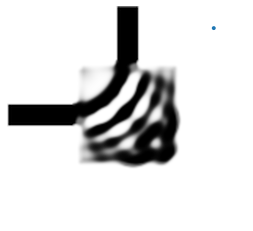

Current iteration: 47
Starting forward run...
Starting adjoint run...
Calculating gradient...


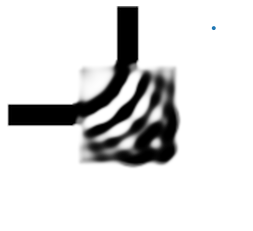

Current iteration: 48
Starting forward run...
Starting adjoint run...
Calculating gradient...


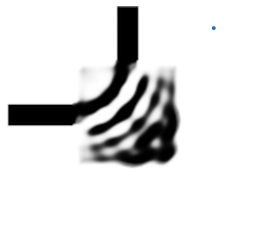

Current iteration: 49
Starting forward run...
Starting adjoint run...
Calculating gradient...


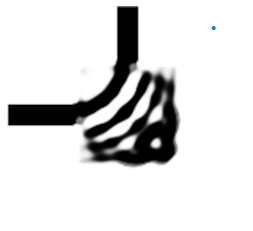

Current iteration: 50
Starting forward run...
Starting adjoint run...
Calculating gradient...


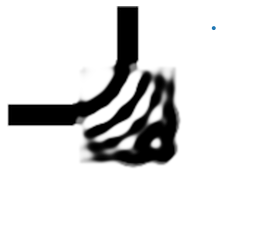

Current iteration: 51
Starting forward run...
Starting adjoint run...
Calculating gradient...


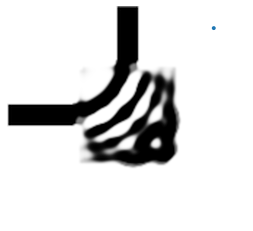

Current iteration: 52
Starting forward run...
Starting adjoint run...
Calculating gradient...


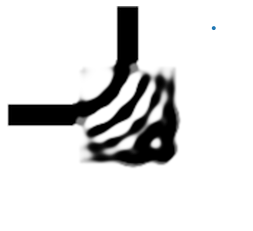

Current iteration: 53
Starting forward run...
Starting adjoint run...
Calculating gradient...


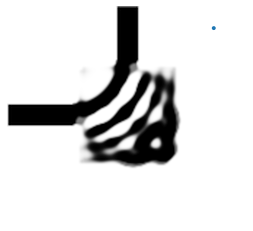

Current iteration: 54
Starting forward run...
Starting adjoint run...
Calculating gradient...


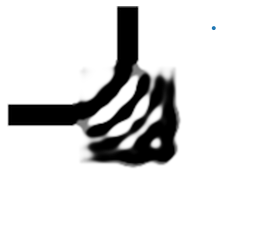

Current iteration: 55
Starting forward run...
Starting adjoint run...
Calculating gradient...


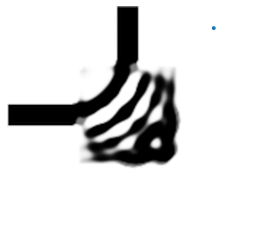

Current iteration: 56
Starting forward run...
Starting adjoint run...
Calculating gradient...


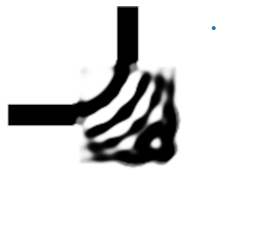

Current iteration: 57
Starting forward run...
Starting adjoint run...
Calculating gradient...


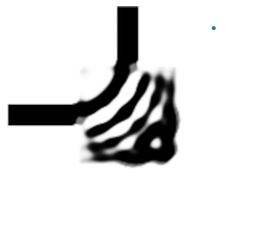

Current iteration: 58
Starting forward run...
Starting adjoint run...
Calculating gradient...


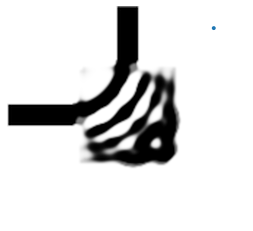

Current iteration: 59
Starting forward run...
Starting adjoint run...
Calculating gradient...


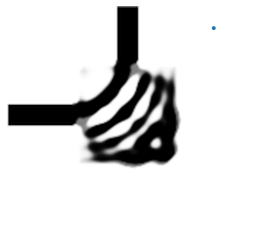

Current iteration: 60
Starting forward run...
Starting adjoint run...
Calculating gradient...


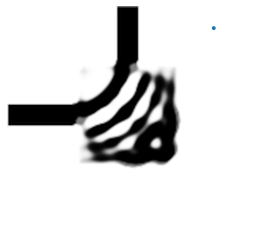

Current iteration: 61
Starting forward run...
Starting adjoint run...
Calculating gradient...


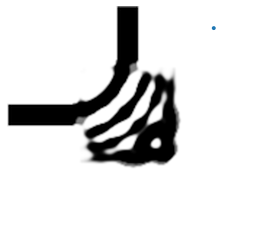

Current iteration: 62
Starting forward run...
Starting adjoint run...
Calculating gradient...


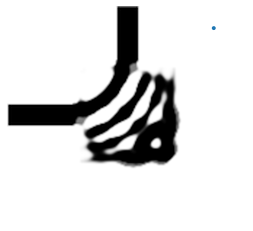

Current iteration: 63
Starting forward run...
Starting adjoint run...
Calculating gradient...


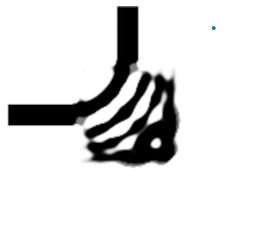

Current iteration: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


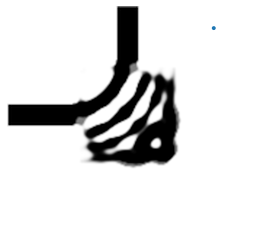

Current iteration: 65
Starting forward run...
Starting adjoint run...
Calculating gradient...


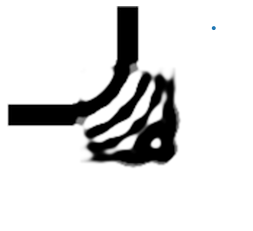

Current iteration: 66
Starting forward run...
Starting adjoint run...
Calculating gradient...


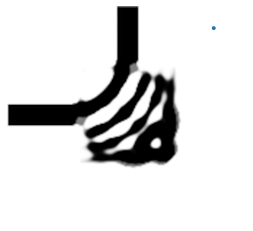

Current iteration: 67
Starting forward run...
Starting adjoint run...
Calculating gradient...


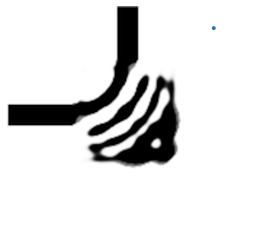

Current iteration: 68
Starting forward run...
Starting adjoint run...
Calculating gradient...


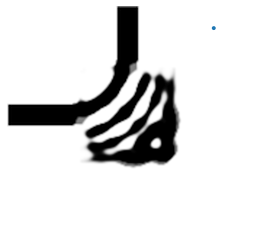

Current iteration: 69
Starting forward run...
Starting adjoint run...
Calculating gradient...


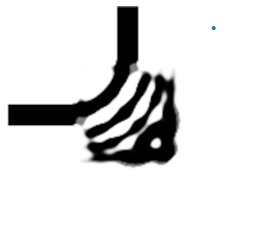

Current iteration: 70
Starting forward run...
Starting adjoint run...
Calculating gradient...


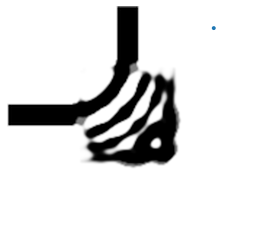

Current iteration: 71
Starting forward run...
Starting adjoint run...
Calculating gradient...


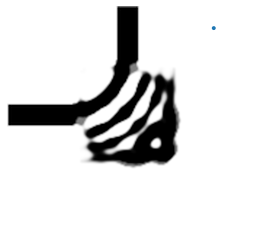

Current iteration: 72
Starting forward run...
Starting adjoint run...
Calculating gradient...


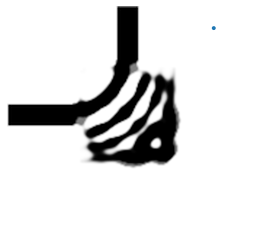

In [14]:
algorithm = nlopt.LD_MMA
n = Nx * Ny # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5
x[Si_mask.flatten()] = 1 # set the edges of waveguides to silicon
x[SiO2_mask.flatten()] = 0 # set the other edges to SiO2

# lower and upper bounds
lb = np.zeros((Nx*Ny,))
lb[Si_mask.flatten()] = 1
ub = np.ones((Nx*Ny,))
ub[SiO2_mask.flatten()] = 0

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 12
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a,g: f(a,g,cur_beta))
    solver.set_maxeval(update_factor)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta*beta_scale

We'll wait for a few minutes (or longer) and visualize the results. We see that every time `beta` increases it either drives the cost function out of a local minimum or into a poorer spot. It gets harder to converge as `beta` increases. This is expected as the gradient starts to swing wildy at these thresholded transition regions. Regardless, we are still able to generate a somewhat smoothed structure after just 72 iterations.

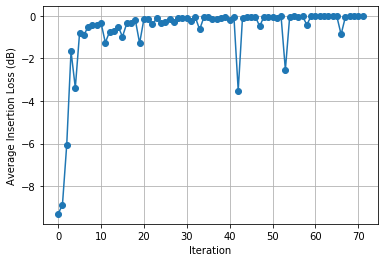

In [15]:
plt.figure()
plt.plot(10*np.log10(evaluation_history),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Average Insertion Loss (dB)')
plt.show()

To be sure, we can plot our results and see the resulting geometry.

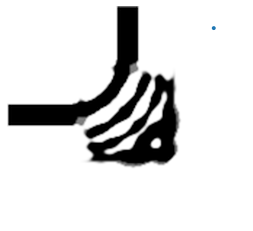

In [16]:
opt.update_design([mapping(x,eta_i,cur_beta)])
plt.figure()
ax = plt.gca()
opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
circ = Circle((2,2),minimum_length/2)
ax.add_patch(circ)
ax.axis('off')
plt.show()

Of course we want to check the final frequency response. We can run another forward run to pull the objective function parameters and calculate the transmisson.

In [17]:
f0, dJ_du = opt([mapping(x,eta_i,cur_beta)],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2

Starting forward run...


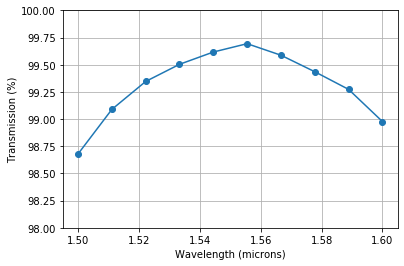

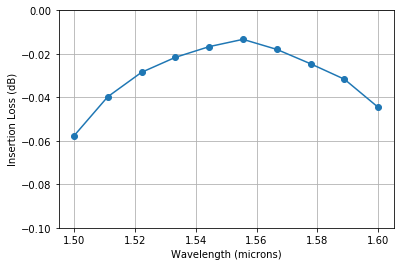

In [18]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o')
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transmission (%)')
plt.ylim(98,100)
plt.show()

plt.figure()
plt.plot(1/frequencies,10*np.log10(top_profile),'-o')
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion Loss (dB)')
plt.ylim(-0.1,0)
plt.show()

In summary, it is very easy to implement design constraints and density parameter operations using the native adjoint solver interface. One could use this same design flow to implement robus optimization over many frequency points.